# Timeseries by region - Adelie Penguin colonies
- Plot regional timeseries by decade
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- February 2025

In [1]:
import utils
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors as c
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load regional masks
- WS = Weddell Sea
- PB = East Antarctic - Prydz Bay
- DU = East Antarctic - D'Urville
- RS = Ross Sea
- AS = Amundsen Sea
- AP = Antarctic Peninsula

Get these from both the CCAMLR mask file and the story regions

In [2]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [3]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

In [4]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [5]:
# Read in "story regions"
file_in = 'antarctic_polygons/antarctic_polygon_areas_v3.nc'
ds_stories= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [6]:
# make region_list
region_list = ['Weddell', 'Prydz', 'DUrville', 'Ross', 'Amundsen', 'Peninsula']

In [7]:
# keep masks for regions of interest
WS_region = ds_ccamlr.mpa_plan_3
PB_region = ds_stories.story_prydz
DU_region = ds_stories.story_durville
RS_region = ds_stories.story_ross
AS_region = ds_stories.story_amundsen
AP_region = ds_ccamlr.mpa_plan_1_mod

In [8]:
# concatenate into a single mask array for easier use

region_masks = xr.concat([WS_region, PB_region, DU_region,
                          RS_region, AS_region, AP_region],
                         dim='region')
region_masks['region'] = region_list

## Load the Penguin Data

In [9]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

### Load the data

In [10]:
# these population projections are for years 1859-2100
years = np.arange(1859,2101,1)
tlen = len(years)
print(tlen)

242


In [11]:
# load future Emperor Penguin population projections
file_in = 'Adelie_region_future_projections_median.csv'
data = pd.read_csv(dir_in + file_in)

In [12]:
data

,WS,EA1,EA2,EA3,EA4,DUR,RSR,AMD,AP
0,3.919151e+06,202162.5000,331548.0000,4155.250000,5.378658e+05,323021.5000,2156077.000,586780.5000,780589.30000
1,3.916743e+06,208008.4371,339165.1922,4273.765084,5.526865e+05,329352.1734,2169905.437,582071.5414,746395.68060
2,3.882161e+06,213992.9554,344756.3067,4368.307594,5.625031e+05,337523.0986,2160654.658,582172.3900,702888.31810
3,3.890486e+06,218629.5972,355775.5683,4343.133033,5.840382e+05,344721.2327,2189797.289,582777.8718,669726.62640
4,3.907474e+06,224050.2335,359962.4439,4600.238590,5.915319e+05,350378.7987,2201169.372,579329.8629,631462.00870
...,...,...,...,...,...,...,...,...,...
237,9.273928e+05,385798.2478,743147.2938,5531.877423,1.113698e+06,572670.3536,2899516.007,742857.6801,66378.42481
238,9.059132e+05,385843.9873,752531.7248,5394.086254,1.114813e+06,569480.9906,2883565.788,743536.9161,63124.88935
239,8.769380e+05,385213.3030,717443.5329,5198.360383,1.111646e+06,572965.7396,2905643.063,747527.7136,62354.53333
240,8.459172e+05,380431.0214,718575.1485,4923.475596,1.108879e+06,564572.8361,2896573.449,753441.0735,60098.94309


In [13]:
# save list of region IDs (these correspond to map)
regions = list(data)

In [14]:
# convert future data to xarray
data = xr.DataArray(data,dims=('year','regions'))

In [15]:
# assign metadata
data['year'] = years
data['regions'] = regions

## Calculate decadal averages

In [16]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [17]:
# get dimensions of the grid we need to iterate over
rlen = len(data.regions)
dlen = len(decades)
print(rlen,dlen)

9 14


In [18]:
# Loop through decades

# make numpy array to fill and specify dimensions
array_decadal_all = np.zeros([dlen,rlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset
    temp1 = data.where((data.year >= yy_st)&(data.year < yy_ed),drop=True)
    # get mean over time
    array_decadal_all[count,:] = temp1.mean(dim='year')

# convert to xarray
data_dec = xr.DataArray(array_decadal_all,dims=('decades','regions'))
data_dec['decades'] = decades
data_dec['regions'] = data.regions

Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


## Figure out which Regions correspond to these and the other variables

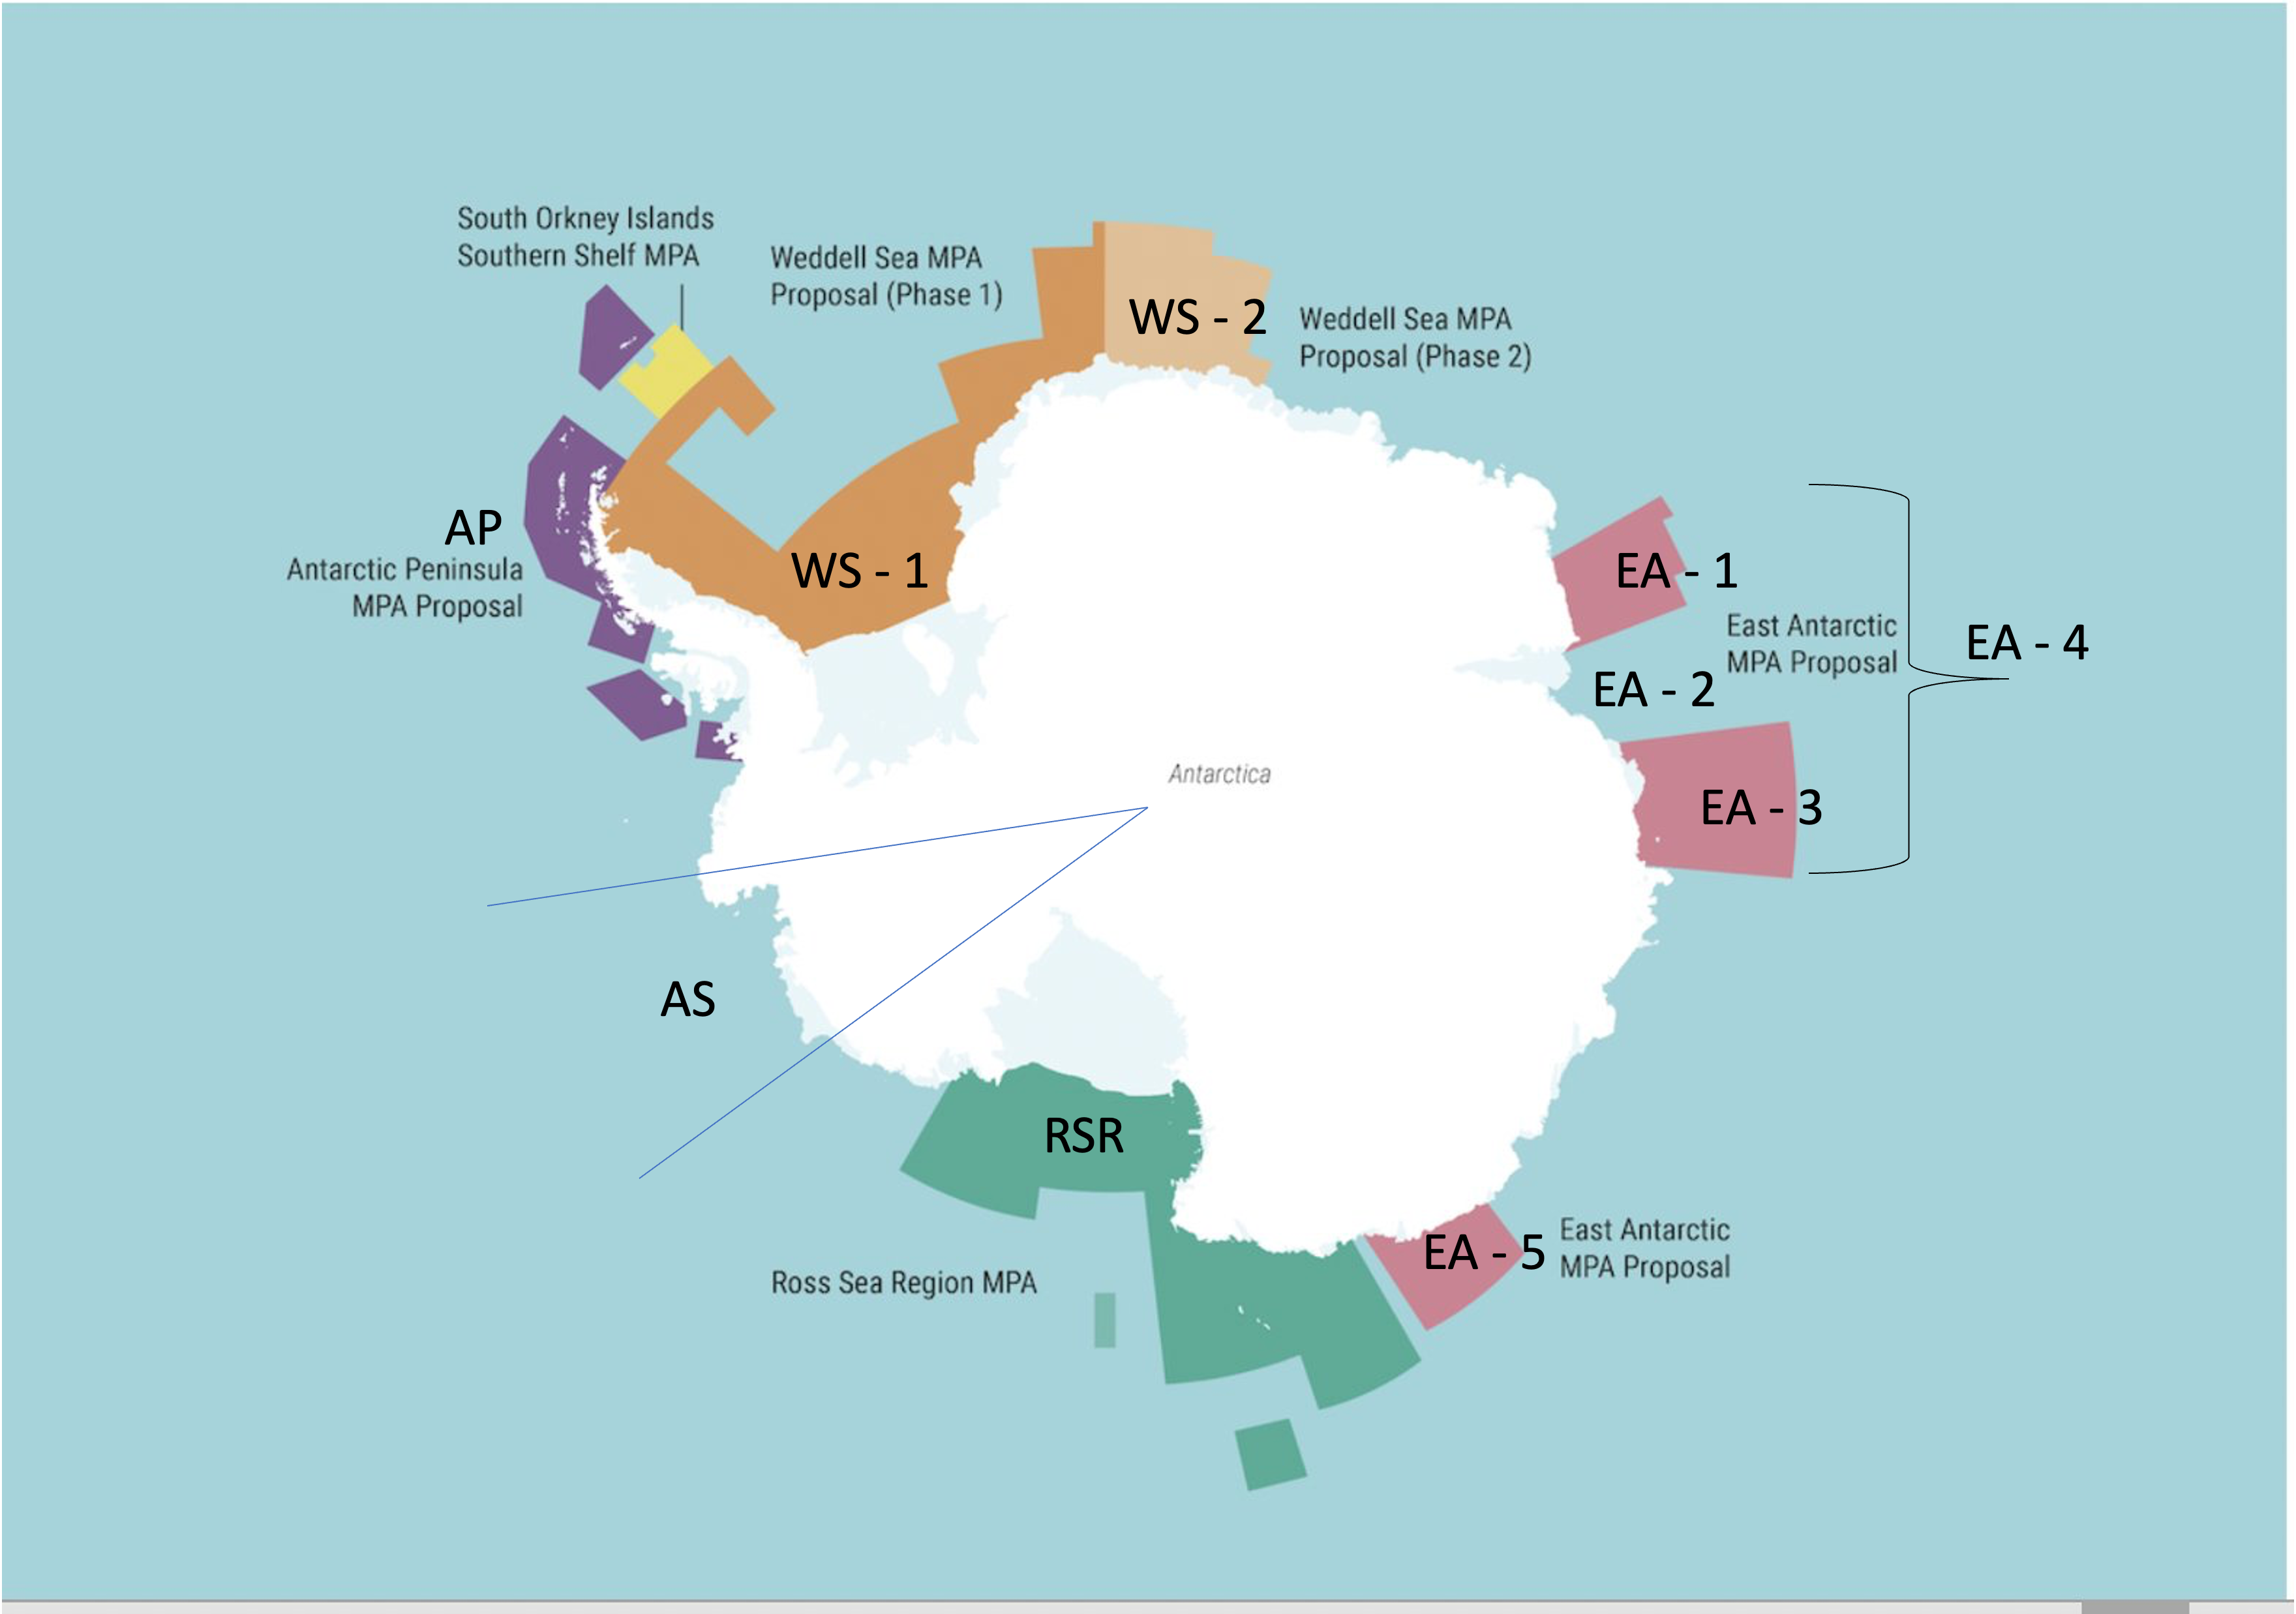

In [19]:
data_dec.regions

<xarray.DataArray 'regions' (regions: 9)>
array(['WS', 'EA1', 'EA2', 'EA3', 'EA4', 'DUR', 'RSR', 'AMD', 'AP'],
      dtype='<U3')
Coordinates:
  * regions  (regions) <U3 'WS' 'EA1' 'EA2' 'EA3' 'EA4' 'DUR' 'RSR' 'AMD' 'AP'

- Note that in the figure above and regions array DUR=EA-5 and AMD=AS

### Keep only regions of interest and rename them to match other files

* Region list from grid file has these regions: ['Weddell', 'Prydz', 'DUrville', 'Ross', 'Amundsen', 'Peninsula']
* These correspond to the following regions in the penguin file: ['WS1','EA4','DUR','RSR','AMD','AP']

In [20]:
WS_data = data_dec.sel(regions='WS')
PB_data = data_dec.sel(regions='EA4')
DU_data = data_dec.sel(regions='DUR')
RS_data = data_dec.sel(regions='RSR')
AS_data = data_dec.sel(regions='AMD')
AP_data = data_dec.sel(regions='AP')

In [21]:
data_region = xr.concat([WS_data, PB_data, DU_data,
                          RS_data, AS_data, AP_data],
                         dim='region')
data_region['region'] = region_list

In [22]:
data_region.region

<xarray.DataArray 'region' (region: 6)>
array(['Weddell', 'Prydz', 'DUrville', 'Ross', 'Amundsen', 'Peninsula'],
      dtype='<U9')
Coordinates:
    regions  (region) <U3 'WS' 'EA4' 'DUR' 'RSR' 'AMD' 'AP'
  * region   (region) <U9 'Weddell' 'Prydz' ... 'Amundsen' 'Peninsula'

## Plot figures

- Plot regional timeseries by decade

In [23]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'

### Plot EP

In [24]:
fout = 'Figure_4_regional_AP_timeseries'
data_plt = data_region/1000000.0
units = r'# x $10^{6}$ Penguins'
label = 'APP'+'\n('+units+')'
#label = r'Ad$\acute{e}$lie Penguin Population'+'\n('+units+')'

# array against which to plot
decades_plt = data_plt.decades

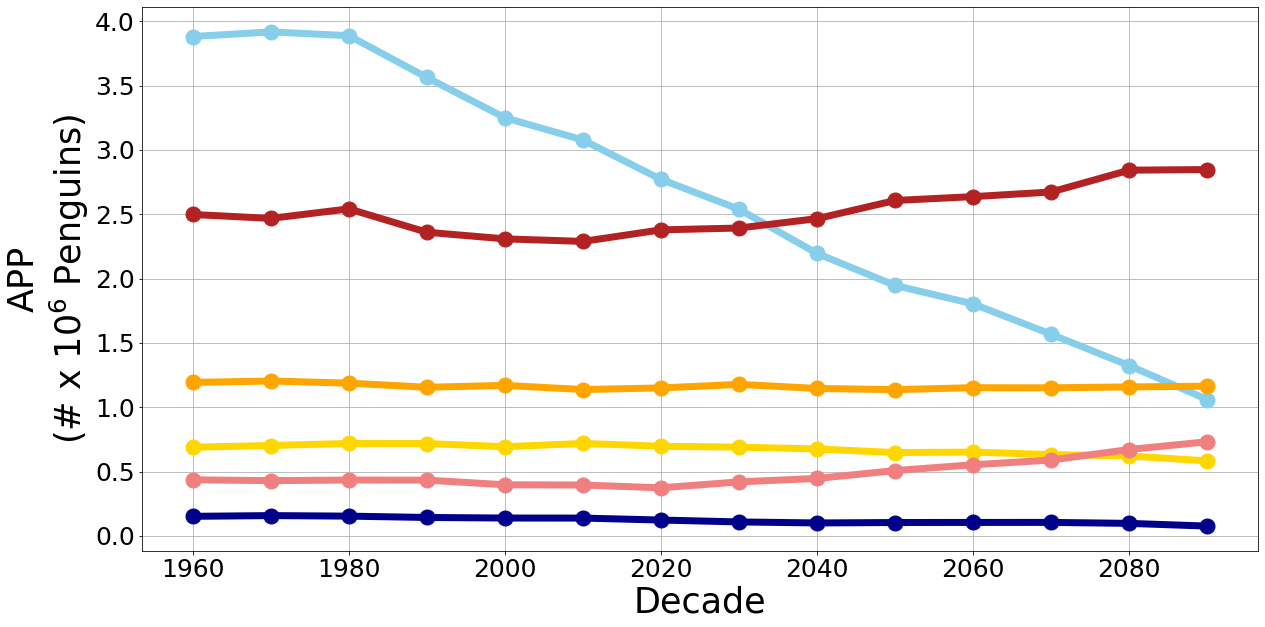

In [25]:
# create figure
fig = plt.figure(figsize=(20,10))

# Make subplots - note it's nrow x ncol x index (starting upper left)
### first subplot
ax = fig.add_subplot(1,1,1)
# plot the regions of interest
ax.plot(decades_plt,data_plt.sel(region='Peninsula'),label="Peninsula",color='darkblue',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='Weddell'),label="Weddell",color='skyblue',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='Prydz'),label="Prydz",color='orange',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='DUrville'),label="D'Urville",color='gold',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='Ross'),label="Ross",color='firebrick',linestyle='-',linewidth=7,marker='o',markersize=15)
ax.plot(decades_plt,data_plt.sel(region='Amundsen'),label="Amundsen",color='lightcoral',linestyle='-',linewidth=7,marker='o',markersize=15)

# final plot tweaks    
plt.xlabel('Decade',fontsize=35)
plt.xticks(fontsize=25)
plt.ylabel(label,fontsize=35)
plt.yticks(fontsize=25)
#plt.legend(loc='lower left', ncol=1,fontsize=20);
plt.grid()

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)